In [1]:
import pandas as pd
import numpy as np
from itertools import product
from ast import literal_eval
import seaborn as sns
import random
import matplotlib.pyplot as plt
import copy
import networkx as nx
from scipy import integrate

In [5]:
cntry_cntry_dis_df=pd.read_csv("..//..//..//data//Data//DerivedData//Derived//funding_source_target_dis.csv")
cntry_cntry_dis_df.head()

,source,target,year,discipline,unit
0,Afghanistan,Afghanistan,2010,66,0.500000
1,Afghanistan,Australia,2018,69,0.333333
2,Afghanistan,Bangladesh,2011,47,0.666667
3,Afghanistan,Bolivia,2016,71,0.125000
4,Afghanistan,Canada,2015,71,0.333333


In [6]:
cntry_cntry_df=cntry_cntry_dis_df.groupby(['source','target'])['unit'].sum().reset_index()
cntry_cntry_df.head()

,source,target,unit
0,Afghanistan,Afghanistan,0.500000
1,Afghanistan,Australia,0.333333
2,Afghanistan,Bangladesh,0.666667
3,Afghanistan,Bolivia,0.125000
4,Afghanistan,Canada,1.132576


In [7]:
cntry_cntry_df.columns=['source','target','weight']
net_flow=nx.from_pandas_edgelist(
    cntry_cntry_df,edge_attr='weight',create_using=nx.DiGraph())

In [4]:
year_a=[2009]
cntry_cntry_filter=cntry_cntry_df[cntry_cntry_df.year.isin(year_a)].groupby(
    ['source','target'])['unit'].sum().reset_index()
cntry_cntry_filter.columns=['source','target','weight']
network_a=nx.from_pandas_edgelist(
    cntry_cntry_filter,edge_attr='weight',create_using=nx.DiGraph())

In [22]:
alpha=0.01
years=np.arange(2009,2019)
rec_df=pd.DataFrame()
for year in years:
    cntry_cntry_filter=cntry_cntry_df[cntry_cntry_df.year==year][[
        'source','target','unit']]
    cntry_cntry_filter.columns=['source','target','weight']
    unitflow_net=nx.from_pandas_edgelist(
    cntry_cntry_filter,edge_attr='weight',create_using=nx.DiGraph())
    unitflow_net.remove_edges_from(nx.selfloop_edges(unitflow_net))
    unitflow_filter=disparity_filter(unitflow_net)
    unitnet_df=nx.to_pandas_edgelist(unitflow_filter)
    unitnet_df=unitnet_df.fillna(0)
    unitnet_df=unitnet_df[(unitnet_df.alpha_in<alpha)]
    out_df=unitnet_df.groupby('source').size().reset_index()
    out_df.columns=['country','out']
    in_df=unitnet_df.groupby('target').size().reset_index()
    in_df.columns=['country','in']
    res_df=out_df.merge(in_df, on='country', how='outer')
    res_df['year']=year
    rec_df=pd.concat([res_df,rec_df])

In [22]:
def add_attribute(G, attr_file):
    nodeset=list(G.nodes)
    attr_set=attr_file[attr_file.country.isin(nodeset)]
    attr_set=dict(zip(attr_set.country, attr_set.region))
    nx.set_node_attributes(G,attr_set,"region")
    return G

In [30]:
unitflow_filter=add_attribute(unitflow_filter, cntry_region)
nx.write_gexf(unitflow_filter, "unitflow_alpha0.01.gexf")

In [20]:
cntry_region=pd.read_csv("cntry_region.csv")
cntry_region.head()

,country,region
0,Afghanistan,Asia
1,Albania,Europe
2,Algeria,Africa
3,American-Samoa,Oceania
4,Andorra,Europe


In [23]:
rec_df=rec_df.fillna(0)
rec_df

,country,out,in,year
0,Argentina,1.0,4.0,2018
1,Australia,8.0,3.0,2018
2,Austria,1.0,5.0,2018
3,Brazil,15.0,6.0,2018
4,Canada,5.0,3.0,2018
...,...,...,...,...
134,Vatican,0.0,1.0,2009
135,Venezuela,0.0,2.0,2009
136,Vietnam,0.0,2.0,2009
137,Zambia,0.0,1.0,2009


In [20]:
out_df=rec_df[['country','out','year']]
cntrysub = out_df.query('year==2018').sort_values(by='out',ascending=False).head(10).country.tolist()
cntrysub_y=out_df.query('year==2018').sort_values(
    by='out',ascending=False).head(10)['out'].tolist()

out_filter=out_df[out_df.country.isin(cntrysub)]

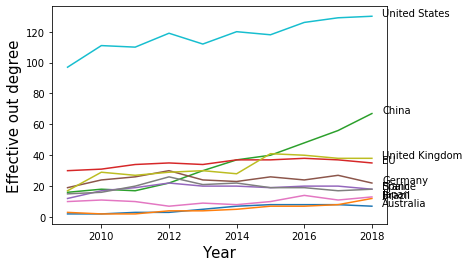

In [21]:
sns.lineplot(x='year',y='out',hue='country',data=out_filter,legend=False)
for index,s in enumerate(cntrysub):
    plt.text(2018.3,cntrysub_y[index],s)
plt.ylabel('Effective out degree',fontsize=15)
plt.xlabel('Year',fontsize=15)
plt.savefig("in_top10_0005.pdf")

In [8]:

out_df = out_df.pivot(index='country',columns='year',values='out')
out_df=out_df.fillna(0)
out_df

year,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018
country,,,,,,,,,,
Afghanistan,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
Albania,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
Algeria,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,2.0,2.0
Andorra,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0
Angola,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...
Venezuela,4.0,3.0,2.0,3.0,3.0,3.0,3.0,1.0,1.0,1.0
Vietnam,1.0,2.0,2.0,4.0,4.0,6.0,6.0,6.0,6.0,6.0
Yemen,0.0,1.0,1.0,2.0,1.0,0.0,0.0,0.0,1.0,0.0


In [8]:
net_flow

In [9]:
net_flow.remove_edges_from(nx.selfloop_edges(net_flow))

In [25]:
net_flow=disparity_filter(net_flow)
net_df=nx.to_pandas_edgelist(net_flow)

In [26]:
net_df=net_df.fillna(0)
net_filter_df = net_df[ (net_df.alpha_in<0.01)]
net_filter_df.shape

(711, 5)

In [28]:
net_flow_filter = nx.from_pandas_edgelist(
    net_filter_df,edge_attr='weight',create_using=nx.DiGraph())

In [29]:
unitflow_filter=add_attribute(net_flow_filter, cntry_region)
nx.write_gexf(unitflow_filter, "unitflow_alpha0.01.gexf")

In [4]:
def disparity_filter(G, weight='weight'):
    ''' Compute significance scores (alpha) for weighted edges in G as defined in Serrano et al. 2009
        Args
            G: Weighted NetworkX graph
        Returns
            Weighted graph with a significance score (alpha) assigned to each edge
        References
            M. A. Serrano et al. (2009) Extracting the Multiscale backbone of complex weighted networks. PNAS, 106:16, pp. 6483-6488.
    '''
    
    if nx.is_directed(G): #directed case    
        N = nx.DiGraph()
        for u in G:
            
            k_out = G.out_degree(u)
            k_in = G.in_degree(u)
            
            if k_out > 1:
                sum_w_out = sum(np.absolute(G[u][v][weight]) for v in G.successors(u))
                for v in G.successors(u):
                    w = G[u][v][weight]
                    p_ij_out = float(np.absolute(w))/sum_w_out
                    alpha_ij_out = 1 - (k_out-1) * integrate.quad(lambda x: (1-x)**(k_out-2), 0, p_ij_out)[0]
                    N.add_edge(u, v, weight = w, alpha_out=float('%.4f' % alpha_ij_out))
                    
            elif k_out == 1 and G.in_degree(list(G.successors(u))[0]) == 1:
                #we need to keep the connection as it is the only way to maintain the connectivity of the network
                v = G.successors(u)[0]
                w = G[u][v][weight]
                N.add_edge(u, v, weight = w, alpha_out=0., alpha_in=0.)
                #there is no need to do the same for the k_in, since the link is built already from the tail
            
            if k_in > 1:
                sum_w_in = sum(np.absolute(G[v][u][weight]) for v in G.predecessors(u))
                for v in G.predecessors(u):
                    w = G[v][u][weight]
                    p_ij_in = float(np.absolute(w))/sum_w_in
                    alpha_ij_in = 1 - (k_in-1) * integrate.quad(lambda x: (1-x)**(k_in-2), 0, p_ij_in)[0]
                    N.add_edge(v, u, weight = w, alpha_in=float('%.4f' % alpha_ij_in))
        return N
    
    else: #undirected case
        B = nx.Graph()
        for u in G:
            k = len(G[u])
            if k > 1:
                sum_w = sum(np.absolute(G[u][v][weight]) for v in G[u])
                for v in G[u]:
                    w = G[u][v][weight]
                    p_ij = float(np.absolute(w))/sum_w
                    alpha_ij = 1 - (k-1) * integrate.quad(lambda x: (1-x)**(k-2), 0, p_ij)[0]
                    B.add_edge(u, v, weight = w, alpha=float('%.4f' % alpha_ij))
        return B
